In [1]:
import kooplearn
import kooplearn.datasets
import matplotlib.pyplot as plt


In [2]:
import logging
import math
from pathlib import Path
from typing import Optional

import numpy as np
import scipy
import scipy.sparse
from scipy.integrate import romb
from scipy.special import binom
from scipy.stats.sampling import NumericalInversePolynomial

from kooplearn._src.utils import topk
from kooplearn.datasets.misc import (
    DataGenerator,
    DiscreteTimeDynamics,
    LinalgDecomposition,
)
import tqdm

from kooplearn.datasets.stochastic import LangevinTripleWell1D
class LangevinTripleWell1D(DiscreteTimeDynamics):
    def __init__(
        self,
        gamma: float = 0.1,
        kt: float = 1.0,
        dt: float = 1e-4,
        rng_seed: Optional[int] = None,
        height=0.1,
        sigma=0.05,
        freq=500
    ):
        self.gamma = gamma
        self.kt = kt
        self.rng = np.random.default_rng(rng_seed)
        self.dt = dt

        self._inv_gamma = (self.gamma) ** -1
        self.list_centers = []
        self.height = height
        self.sigma = sigma
        self.freq = freq
    def sample(self, X0: np.ndarray, T: int = 1, show_progress: bool = False):
        X0 = np.asarray(X0)
        if X0.ndim == 0:
            X0 = X0[None]

        memory = np.zeros((T + 1,) + X0.shape)
        meta_forces = np.zeros((T + 1,) + X0.shape)
        forces = np.zeros((T + 1,) + X0.shape)
        memory[0] = X0
        show_progress = True
        if show_progress:
            _iter = tqdm.tqdm(range(T), desc="Generating data", unit="step", leave=False)
        else:
            _iter = range(T)

        for t in _iter:
            if t% self.freq ==0 and t !=0:
                self.list_centers.append(memory[t])
            memory[t + 1], forces[t+1], meta_forces[t + 1] = self._step(memory[t])
        return memory, forces, meta_forces
    def eig(self):
        if not hasattr(self, "_ref_evd"):
            self._compute_ref_evd()
        return self._ref_evd
    def _compute_ref_evd(self):
        assets_path = Path(__file__).parent / "assets"

        lap_x = scipy.sparse.load_npz(assets_path / "1D_triple_well_lap_x.npz")
        grad_x = scipy.sparse.load_npz(assets_path / "1D_triple_well_grad_x.npz")
        cc = np.load(assets_path / "1D_triple_well_cc.npz")

        force = scipy.sparse.diags(self.force_fn(cc))

        # Eq.(31) of https://doi.org/10.1007/978-3-642-56589-2_9 recalling that \sigma^2/(\gamma*2) = kBT
        generator = self._inv_gamma * self.kt * lap_x + self._inv_gamma * force.dot(
            grad_x
        )
        generator = generator * self.dt

        vals, vecs = np.linalg.eig(generator.toarray())

        # Filter out timescales smaller than dt
        mask = np.abs(vals.real) < 1.0
        vals = vals[mask]
        vecs = vecs[:, mask]

        vals = np.exp(vals)
        # Checking that the eigenvalues are real
        type_ = vals.dtype.type
        f = np.finfo(type_).eps

        tol = f * 1000
        if not np.all(np.abs(vals.imag) < tol):
            raise ValueError(
                "The computed eigenvalues are not real, try to decrease dt"
            )
        else:
            vals = vals.real

        _k = len(vals)
        evd_sorting_perm = topk(vals, _k)
        vals = evd_sorting_perm.values
        vecs = vecs[:, evd_sorting_perm.indices].real

        dx = cc[1] - cc[0]
        boltzmann_pdf = (dx**-1) * scipy.special.softmax(self.force_fn(cc) / self.kt)
        abs2_eigfun = (np.abs(vecs) ** 2).T
        eigfuns_norms = np.sqrt(romb(boltzmann_pdf * abs2_eigfun, dx=dx, axis=-1))
        vecs = vecs * (eigfuns_norms**-1.0)

        # Storing the results
        self._ref_evd = LinalgDecomposition(vals, cc, vecs)
        self._ref_boltzmann_density = boltzmann_pdf

    def _step(self, X: np.ndarray):
        F, bias = self.force_fn(X)
        xi = self.rng.standard_normal(X.shape)
        dX = (
            F * self._inv_gamma * self.dt
            + np.sqrt(2.0 * self.kt * self.dt * self._inv_gamma) * xi
        )
        return X + dX, F, bias
    def meta_force(self,x):
        return  ((x - np.array(self.list_centers)) * self.height * np.exp( - ( x - np.array(self.list_centers))**2 / (2 * self.sigma **2))).sum() / (self.sigma**2)
    def force_fn(self, x: np.ndarray):
        bias = self.meta_force(x)
        return -4.0 * (
            -32 * np.exp(-80 * ((-0.5 + x) ** 2)) * (-0.5 + x)
            - 512 * np.exp(-80 * (x**2)) * x
            + 8* (x**7)
            - 40 * np.exp(-40 * ((0.5 + x) ** 2)) * (0.5 + x)
        )+ bias, bias  #-8*(x-1)*(x+1)**2 - 8*(x-1)**2*(x+1)


In [3]:
langevin = LangevinTripleWell1D(rng_seed=0,gamma=0.1,dt=1e-4,height=0.1,sigma=0.1,freq=1000) #sigma=0.1

In [4]:
sample,forces, meta_forces = langevin.sample(0, 1_000_000)

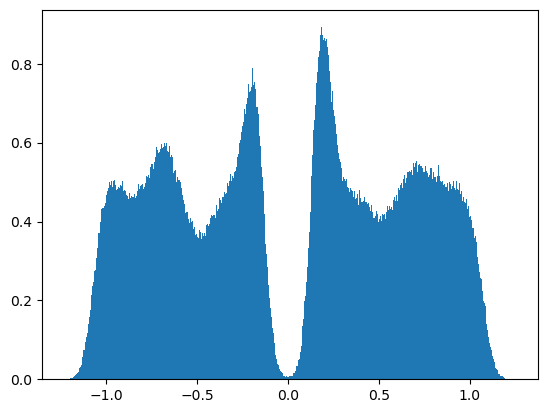

In [5]:
plt.hist(sample, bins=500, density=True);

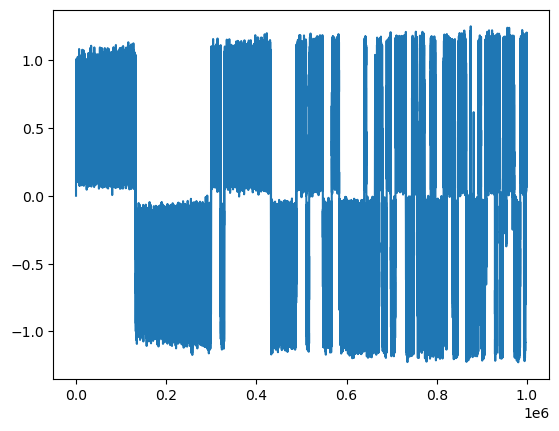

In [6]:
plt.plot(sample)


In [ ]:
from sklearn.gaussian_process.kernels import RBF
from kooplearn.data import traj_to_contexts

kernel = RBF(length_scale=0.3) #0.65 works  well #0.4 best
model = kooplearn.models.KernelDMD(kernel, reduced_rank=True, rank=6
                                   
                                   , tikhonov_reg=1e-2
                                   , fit_generator=True,mean_features=False)

In [ ]:
def force(x):
    return -40*x*(x**2-1)
test=sample[:200_000:50]
train_data = traj_to_contexts(test)
forces_train = traj_to_contexts(forces[:200_000:50])
train_data.shape
bias = traj_to_contexts(meta_forces[:200_000:50])
print(bias.shape)

(3999, 2, 1)


In [192]:
model = model.fit(train_data,forces=(forces_train-bias)/0.1,friction=2/0.1) #np.sqrt(2))


hello
0.3
[[0.]]
Fitting transfer operator
Fitting generator
Fitted KernelDMD model. Lookback length set to 1


In [193]:
vals,vals_gen,vecs,vecs_gen = model.eig(eval_right_on=train_data[:,:1, ...])

In [194]:
vals_gen = vals_gen[np.where(np.abs(vals_gen)>1e-3)]


In [195]:
print(vals_gen)


[-8.14500434e+02+0.j -6.48012660e+02+0.j -2.73348630e+02+0.j
 -2.19916919e+02+0.j -9.78532974e+01+0.j  3.85043874e-02+0.j]


In [196]:
from sklearn.metrics import mean_squared_error

def prediction_error(model, contexts):
    init_frames = contexts[:, :model.lookback_len, ...] # Everything in the lookback window is used for inference
    pred_frames = model.predict(init_frames) # Predicting the future frames
    true_frames = contexts[:, model.lookback_len:, ...].reshape(*pred_frames.shape) # The true frames are everything after the lookback length (i.e. the lookforward window)
    
    return mean_squared_error(true_frames, pred_frames)
prediction_error(model,train_data)

0.04396670909114871

###### 

/home/tdevergne@iit.local/anaconda3/envs/kooplearn-dev/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/tdevergne@iit.local/anaconda3/envs/kooplearn-dev/lib/python3.10/site-packages/matplotlib/collections.py:194: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(array([], dtype=int64),)


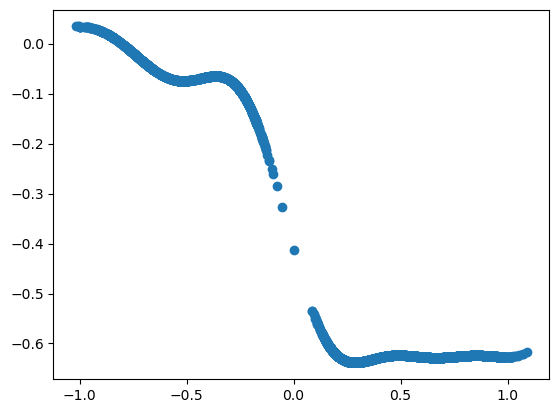

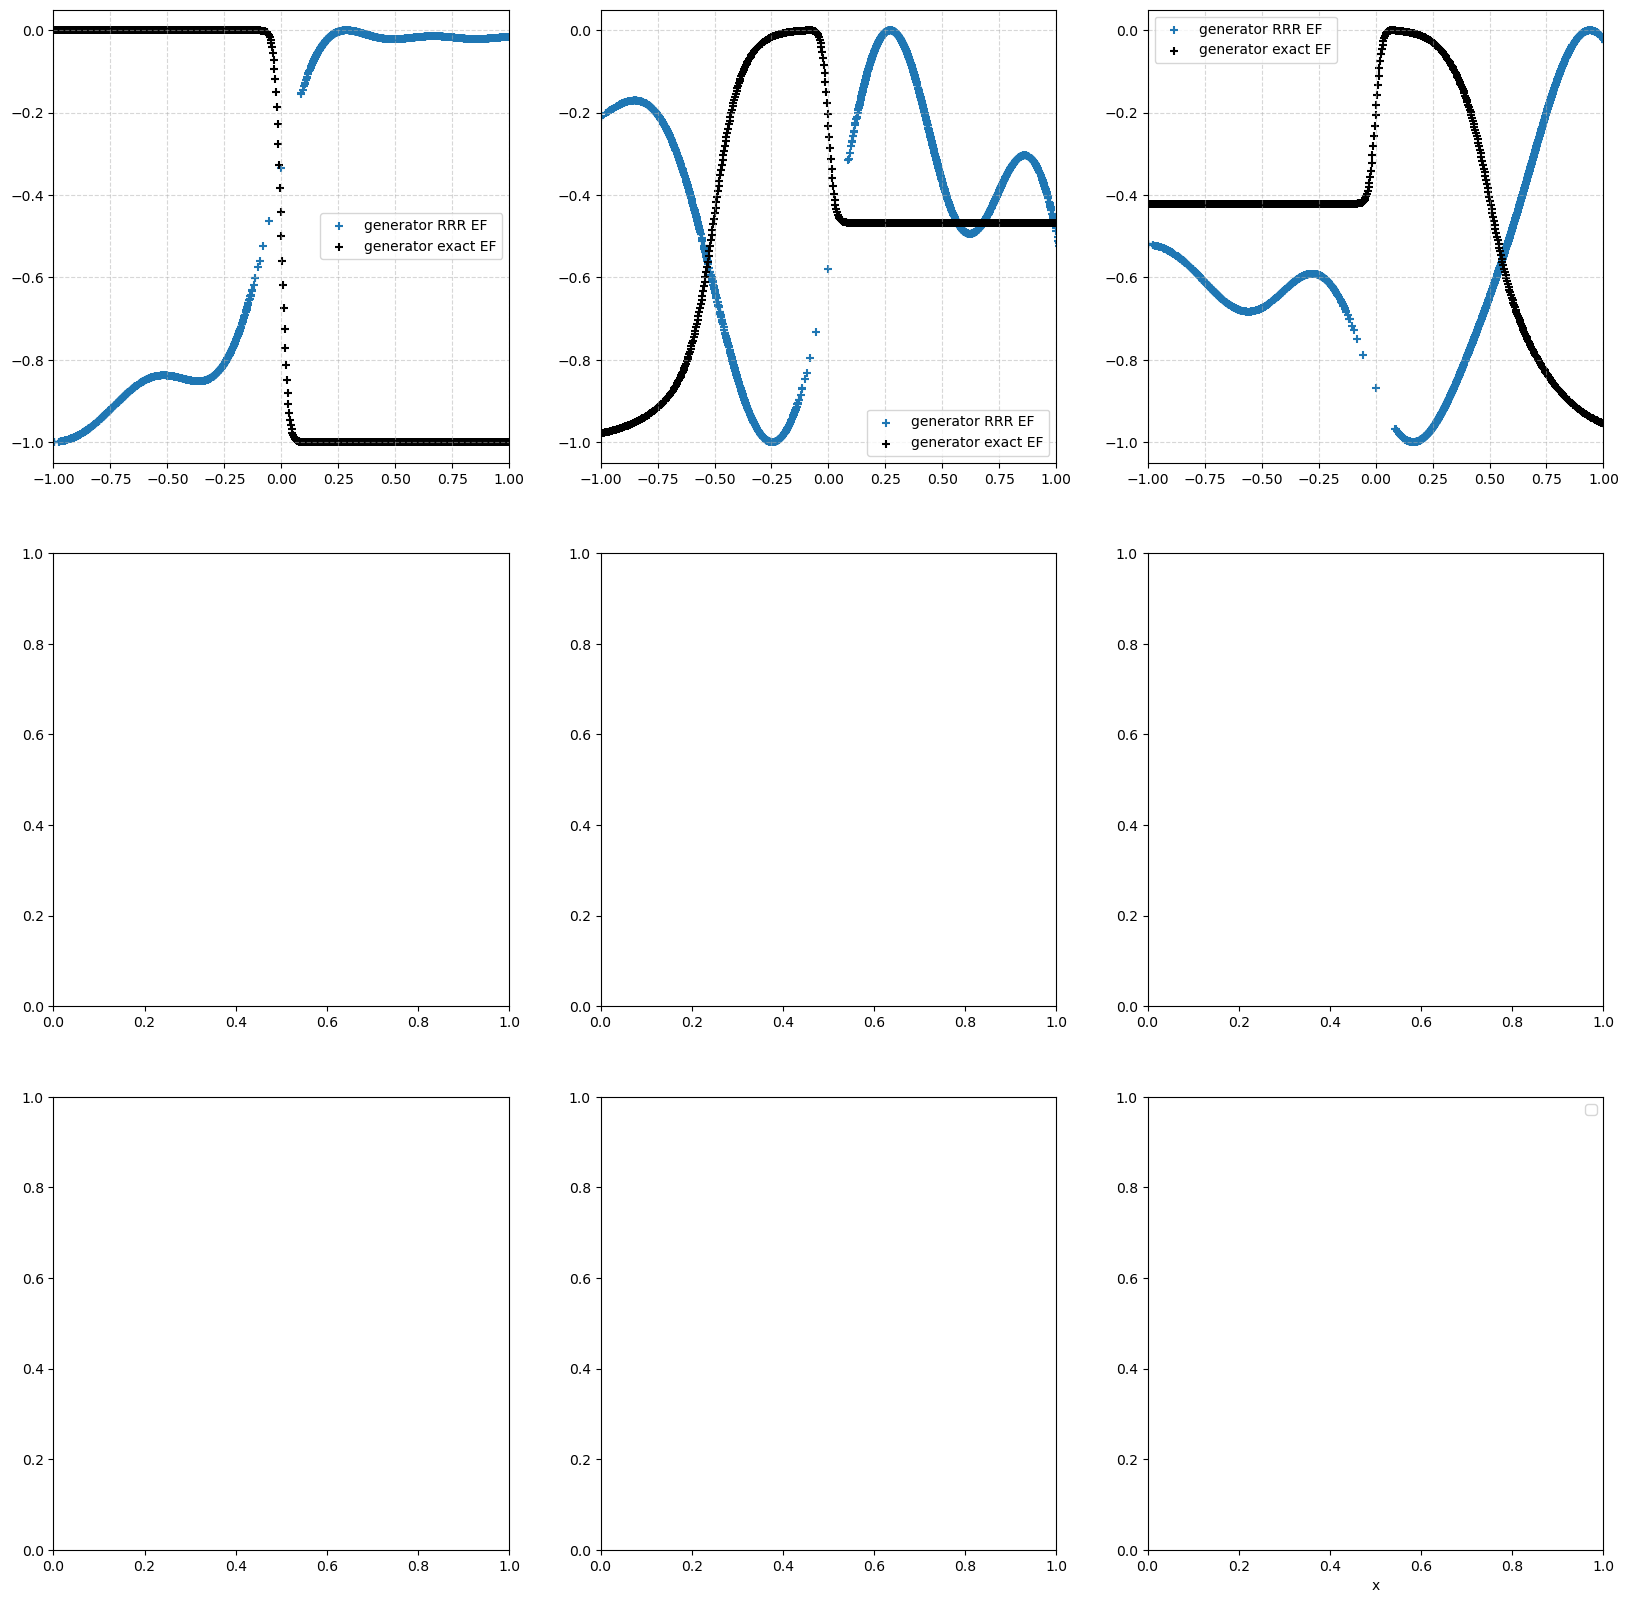

In [197]:
import numpy as np
from scipy.integrate import solve_bvp
import matplotlib.pyplot as plt




solutions =np.load("/home/tdevergne@iit.local/Documents/eigenfunctions.np",allow_pickle=True)
x_values  =np.load("/home/tdevergne@iit.local/Documents/centers.np",allow_pickle=True)
plt.scatter(np.squeeze(train_data[:,:1, ...]),vecs_gen[:,-1],label="PCR generator first eigenfunction")
#plt.scatter(np.squeeze(train_data[:,:1, ...]), vecs[:,-2],label="PCR transfer first eigenfunction")
#plt.plot(decomp.x[values],-funcs[values,2],label="exact eigenfunction",color="r")

plt.plot()
num = 3
fig, axes = plt.subplots(num, num, figsize=(20, 20))
#values = np.where(np.logical_and(decomp.x>-1,decomp.x<1))[0]
print(np.where(vecs_gen[:,-1]==0))

new_0 = -(vecs_gen[:,-1]-vecs_gen[:,-1].min())/(vecs_gen[:,-1].min()-vecs_gen[:,-1].max())

for i in range(3):
    #vecs_gen[:,-i-1] /= vecs_gen[:,-1]
    #vecs_gen[:,-i-1] /= vecs_gen[:,-1]
    new = (vecs_gen[:,-i-1]-vecs_gen[:,-i-1].min())/(vecs_gen[:,-i-1].min()-vecs_gen[:,-i-1].max())
    new_sol = (solutions[:,i+1]-solutions[:,i+1].min())/(solutions[:,i+1].min()-solutions[:,i+1].max())
    new_vecs = (vecs[:,-i-1]-vecs[:,-i-1].min())/(vecs[:,-i-1].min()-vecs[:,-i-1].max())
    if  i==2:
        axes[i//num, i%num].scatter(np.squeeze(train_data[:,:1, ...]), -new-1, marker="+", color='C0',label="generator RRR EF")
    else:
        axes[i//num, i%num].scatter(np.squeeze(train_data[:,:1, ...]), new, marker="+", color='C0',label="generator RRR EF")
    axes[i//num, i%num].scatter(x_values,new_sol, marker="+", color='k', label="generator exact EF")
    #axes[i//num, i%num].scatter(np.squeeze(train_data[:,:1, ...]),new_vecs, marker="+", color='k', label="generator exact EF")
    axes[i//num, i%num].grid(True, linestyle='--', alpha=.5)
    axes[i//num, i%num].set_xlim(-1, 1)
    #axes[i//num, i%num].set_ylim(y_min, y_max)

    axes[i//num, i%num].legend()

plt.xlabel('x')
#plt.ylabel('')
plt.legend()
plt.show()

In [198]:
plt.plot(decomp.x,funcs[:,1],label="exact eigenfunction",color="r")

NameError: name 'decomp' is not defined

In [ ]:
np.real(vecs_gen[:,-i-1]/vecs_gen[:,-1])

array([-0.08255885, -0.06062868,  0.09228294, ..., -0.01325368,
        0.05357351,  0.07160568])